# PREPARACIÓN DE ENTORNO

### Importación de librerías

In [1]:
import imgaug.augmenters as iaa
import json
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import splitfolders
import tensorflow as tf

from classification_models.tfkeras import Classifiers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

### Importación del modelo pre entrenado

In [2]:
ResNet50, preprocess_input = Classifiers.get('resnet50')
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

94592056/94592056 [==============================] - 9s 0us/step


### Definición de variables

In [3]:
# Ruta del directorio donde están tus datos
input_folder = "/UPC/Tesis/DATASET/Datasetv5"

# Ruta del directorio donde se guardarán los datos divididos
output_folder = "/UPC/Tesis/DATASET/split_data"

model_json_name = "resnet50_model.json"
model_weights_file_name = "resnet50_weights_.hdf5"

# PREPARACIÓN DE DATOS

### División de datos

In [4]:
# Dividir los datos
#splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

### Preprocesamiento de Imágenes

#### Aumento de datos

In [5]:
# Definir aumentos personalizados con imgaug
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Multiply((1.0, 1.196))),               # Brillo
    iaa.Sometimes(0.5, iaa.LinearContrast((0.5, 0.7))),             # Constraste
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(                  # Ruido
        loc=0,
        scale=(0.0, 0.01*255),
        per_channel=0.5
    )),
    iaa.Sometimes(0.5, iaa.GammaContrast((0.97, 1.0))),
    iaa.Sharpen(alpha=(0.1, 0.5), lightness=(0.75, 1.5)),
    iaa.Sometimes(0.5, iaa.WithChannels(0, iaa.Multiply((0.9, 1.1)))),
    iaa.Sometimes(0.5, iaa.WithChannels(1, iaa.Multiply((0.9, 1.1)))),
    iaa.Sometimes(0.5, iaa.WithChannels(2, iaa.Multiply((0.9, 1.1)))),
])

def custom_preprocessing_function(img):
    # Asegurarse de que img es una imagen en el rango [0, 255]
    img = np.array(img, dtype=np.uint8)

    # Aplicar las transformaciones de imgaug
    img = seq.augment_image(img)

    return img

def combined_preprocessing_function(img):
    # Aplicar aumentos de imgaug
    img = custom_preprocessing_function(img)

    # Aplicar preprocesamiento específico del modelo
    img = preprocess_input(img)

    return img

In [6]:
# Crear un generador de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    preprocessing_function=combined_preprocessing_function,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=combined_preprocessing_function,
    fill_mode='nearest'
)

# Crear un flujo de imágenes desde el directorio de entrenamiento
train_generator = train_datagen.flow_from_directory(
    '/UPC/Tesis/DATASET/split_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Crear un flujo de imágenes desde el directorio de entrenamiento
validation_generator = validation_datagen.flow_from_directory(
    '/UPC/Tesis/DATASET/split_data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 330 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


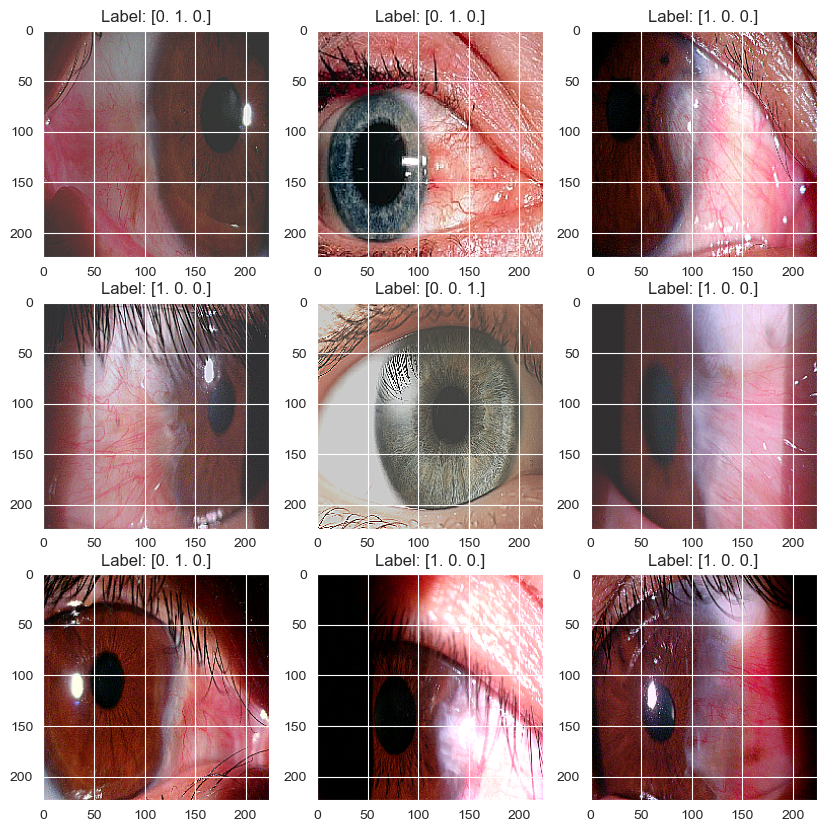

In [7]:
# Asume que datagen y train_generator ya están definidos como antes

# Obtener un lote de imágenes del generador
imgs, labels = next(train_generator)

# Visualizar algunas imágenes del lote
plt.figure(figsize=(10, 10))

# Valores mínimos y máximos en tus datos
min_val = np.min(imgs)
max_val = np.max(imgs)

# Normalizar las imágenes al rango [0, 1]
normalized_imgs = (imgs - min_val) / (max_val - min_val)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(normalized_imgs[i])
    plt.title(f'Label: {labels[i]}')

plt.show()

### Equilibrio de clases

In [8]:
# Obtener las etiquetas del generador
y_labels = train_generator.classes

# Calcular pesos
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

### Visualización de estadística de datos

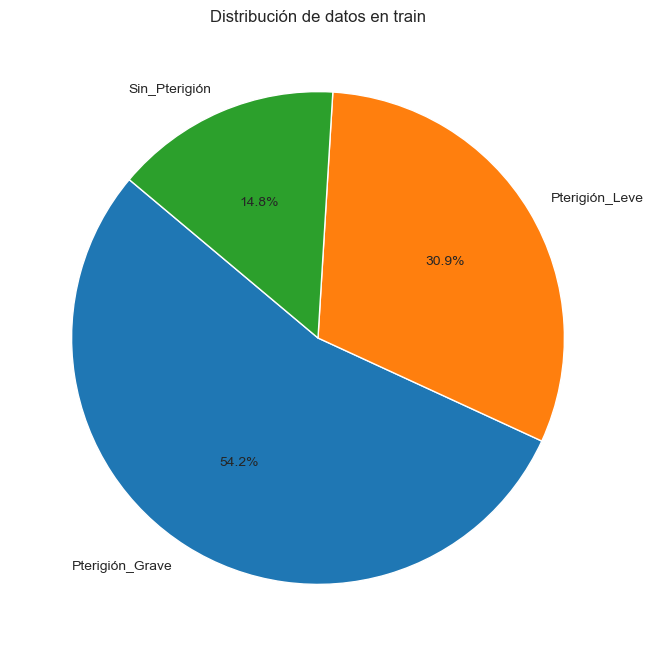

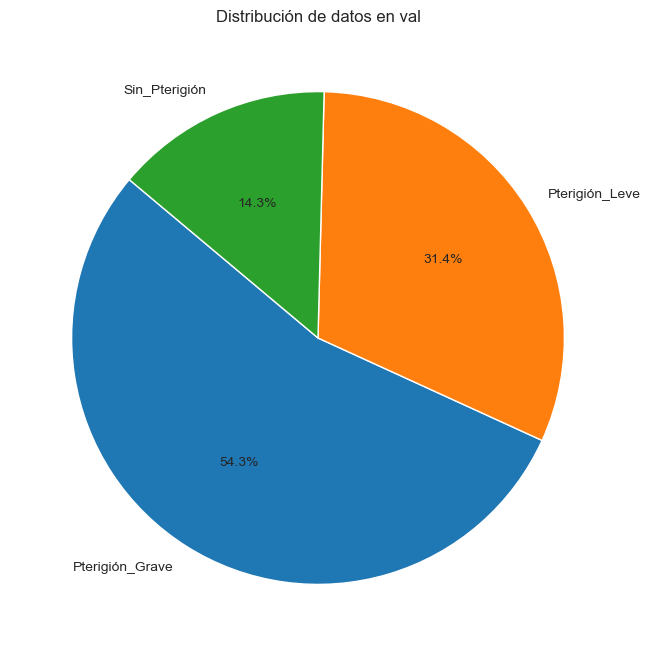

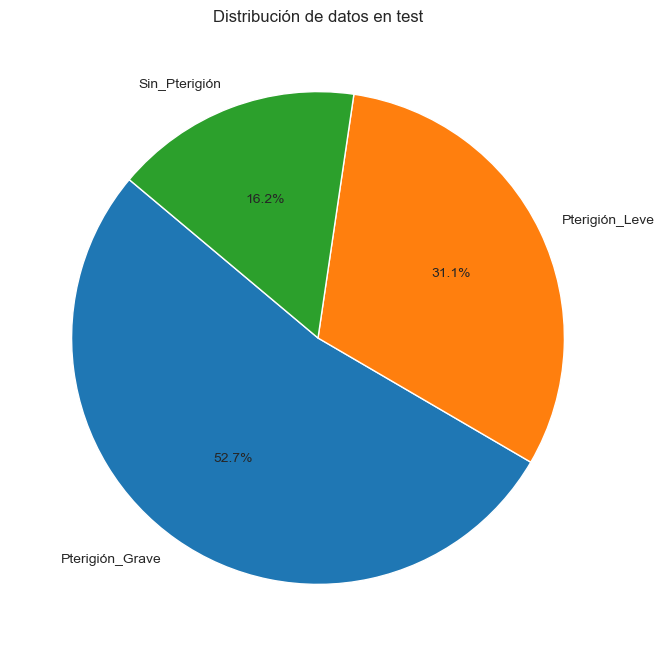

In [9]:
def plot_data_distribution(directory):
    folders = ['train', 'val', 'test']  # Carpetas de datos
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        classes = os.listdir(folder_path)
        class_counts = [len(os.listdir(os.path.join(folder_path, cls))) for cls in classes]

        plt.figure(figsize=(8, 8))
        plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=140)
        plt.title(f'Distribución de datos en {folder}')
        plt.show()

# Llamar a la función
plot_data_distribution(output_folder)

# Configurar y Personalizar ResNeXt50

In [10]:
# Añadir capas personalizadas
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Crear el modelo final
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']   

# Entrenamiento

In [11]:
# Optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Usamos la parada temprana para salir del entenamiento si el error de validación
# no decrece después de cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Guardamos el mejor modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath = model_weights_file_name, verbose = 1, save_best_only=True)

In [13]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpointer, earlystopping]
)

Epoch 1/35
11/11 [==============================] - ETA: 0s - loss: 1.1355 - accuracy: 0.4152
Epoch 1: val_loss improved from inf to 0.94235, saving model to resnet50_weights_.hdf5
11/11 [==============================] - 82s 7s/step - loss: 1.1355 - accuracy: 0.4152 - val_loss: 0.9424 - val_accuracy: 0.6143
Epoch 2/35
11/11 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.6939
Epoch 2: val_loss did not improve from 0.94235
11/11 [==============================] - 59s 5s/step - loss: 0.7076 - accuracy: 0.6939 - val_loss: 0.9678 - val_accuracy: 0.5286
Epoch 3/35
11/11 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8212
Epoch 3: val_loss did not improve from 0.94235
11/11 [==============================] - 59s 5s/step - loss: 0.5143 - accuracy: 0.8212 - val_loss: 1.2305 - val_accuracy: 0.4143
Epoch 4/35
11/11 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8727
Epoch 4: val_loss improved from 0.94235 to 0.84467, savi

# EVALUACION

### Graficos de Accuracy y Loss

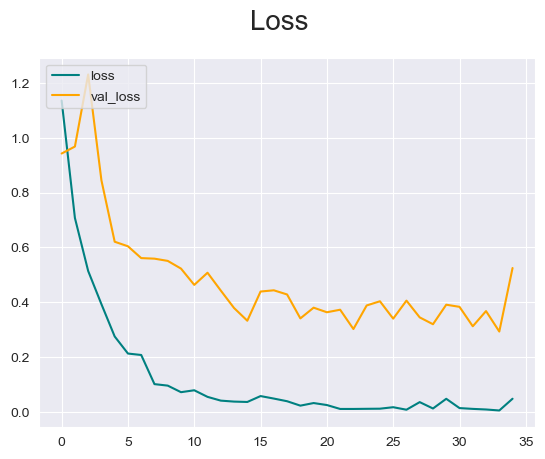

In [14]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

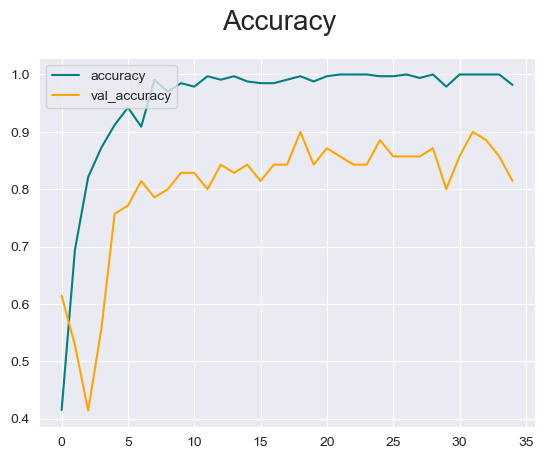

In [15]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluación con datos de testing

In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=combined_preprocessing_function,
    fill_mode='nearest'
)
# Crear un flujo de imágenes desde el directorio de entrenamiento
test_generator = test_datagen.flow_from_directory(
    '/UPC/Tesis/DATASET/split_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 74 images belonging to 3 classes.


In [17]:
# Evaluar el modelo para obtener la pérdida y la precisión (accuracy)
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


3/3 [==============================] - 4s 1s/step - loss: 0.7002 - accuracy: 0.8108
Test Loss: 0.7002081274986267
Test Accuracy: 0.8108108043670654


In [18]:
# Obtén las predicciones del modelo
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convierte las predicciones a etiquetas

# Obtén las etiquetas verdaderas
y_true = test_generator.classes

3/3 [==============================] - 5s 940ms/step


In [19]:
# Obtén la precisión, recall, f1-score, etc.
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

                 precision    recall  f1-score   support

Pterigión_Grave       1.00      0.77      0.87        39
 Pterigión_Leve       0.71      0.74      0.72        23
  Sin_Pterigión       0.60      1.00      0.75        12

       accuracy                           0.80        74
      macro avg       0.77      0.84      0.78        74
   weighted avg       0.84      0.80      0.80        74



In [20]:
# Obtén la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calcula la sensibilidad y especificidad para cada clase
sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1)
specificity = (np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)) / (np.sum(conf_matrix, axis=0) + np.sum(conf_matrix, axis=1) - 2*np.diag(conf_matrix))

print(f'Sensitivity for each class: {sensitivity}')
print(f'Specificity for each class: {specificity}')

Sensitivity for each class: [0.76923077 0.73913043 1.        ]
Specificity for each class: [0.         0.53846154 1.        ]


In [21]:
num_classes = len(np.unique(y_true))  # número de clases
VP = np.diag(conf_matrix)  # Verdaderos Positivos son la diagonal de la matriz de confusión

VN = np.sum(conf_matrix) - np.sum(conf_matrix, axis=0) - np.sum(conf_matrix, axis=1) + VP  # Verdaderos Negativos
FP = np.sum(conf_matrix, axis=0) - VP  # Falsos Positivos
FN = np.sum(conf_matrix, axis=1) - VP  # Falsos Negativos

for i in range(num_classes):
    print(f'Clase {i}: VP={VP[i]}, VN={VN[i]}, FP={FP[i]}, FN={FN[i]}')


Clase 0: VP=30, VN=35, FP=0, FN=9
Clase 1: VP=17, VN=44, FP=7, FN=6
Clase 2: VP=12, VN=54, FP=8, FN=0


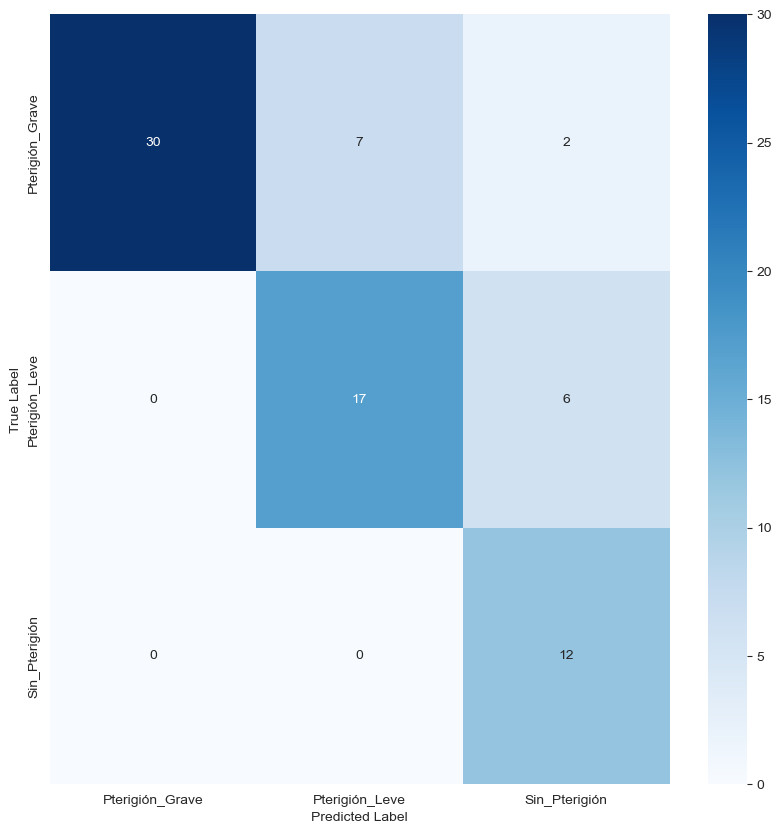

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# GUARDAR EL MODELO

In [23]:
model_json = model.to_json()
with open(model_json_name,"w") as json_file:
    json_file.write(model_json)

In [24]:
with open(model_json_name, 'r') as json_file:
    json_savedModel= json_file.read()

# Cargamos la arquitectura del modelo
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(model_weights_file_name)
model.compile(optimizer = 'SGD', loss = "categorical_crossentropy", metrics = ["accuracy"])

# DESPLEGAR EL MODELO

In [25]:
def deploy(directory, model_file, model_version):
    MODEL_DIR = directory
    version = model_version

    # Juntamos el directorio del temp model con la versión elegida
    # El resultado será = '\tmp\version number'
    export_path = os.path.join(MODEL_DIR, version)
    print('export_path = {}\n'.format(export_path))

    # Guardemos el modelo con saved_model.save
    # Si el directorio existe, debemos borrarlo con '!rm'
    # rm elimina cada fichero especificado usando la consola de comandos.

    if os.path.isdir(export_path):
        print('\nAlready saved a model, cleaning up\n')
        !rm -r {export_path}

    tf.saved_model.save(model_file, export_path)

    os.environ["MODEL_DIR"] = MODEL_DIR